In [1]:
rating_df = pd.read_csv('data/ratings.csv')

print(rating_df.shape)
rating_df.head(3)

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [2]:
rating_df.rating.describe()

count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

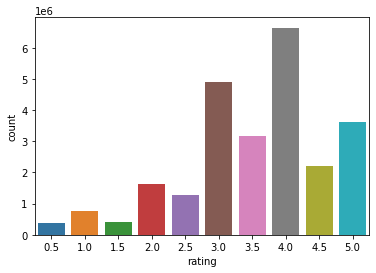

In [3]:
sns.countplot(rating_df.rating);

In [4]:
# 유저 수는 약 162000명, 영화 수는 약 59000개 이다.
print(f"Users : {rating_df.userId.nunique()}")
print(f"Movies : {rating_df.movieId.nunique()}")

Users : 162541
Movies : 59047


In [5]:
# 한 유저가 같은 영화에 대해 두 번 이상 평점을 매긴 경우는 존재하지 않는다.
rating_df.groupby(['userId', 'movieId']).size().value_counts()

1    25000095
dtype: int64

In [6]:
# 해당 데이터는 한 유저가 최소 20개에서부터 최대 약 32000개의 영화에 대해 평점을 매긴 데이터이다.
rating_df.groupby('userId')['movieId'].count().sort_values()

userId
56219        20
87801        20
129589       20
57943        20
129586       20
          ...  
20055      7488
33844      7919
137293     8913
80974      9178
72315     32202
Name: movieId, Length: 162541, dtype: int64

In [7]:
# 한 명의 유저에게 평가받은 영화는 10298개, 두 명의 유저에게 평가받은 영화는 7633개 ... 로 이루어져 있다.
rating_df.groupby('movieId')['userId'].count().value_counts()

1        10298
2         7633
3         4923
4         3473
5         2513
         ...  
4527         1
2508         1
6638         1
10760        1
14329        1
Name: userId, Length: 3820, dtype: int64

---

---

# 상품 중심 협업 필터링

In [2]:
from modules.module import filtering_df, eval_model, trans_interaction_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
filtered_df = filtering_df(rating_df, 100, 50)

del rating_df

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :22488390


In [10]:
# Train, Test Dataset Split
train_df, test_df = train_test_split(filtered_df, random_state=13)

del filtered_df

In [11]:
pivot_df = trans_interaction_matrix(train_df, impute='mean')

print(pivot_df.shape)
pivot_df.head(2)

Return userId-movieId Matrix
(101074, 10291)


movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
1,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,...,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077
2,3.500000,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,...,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839


In [12]:
# 유저-영화 행렬을 영화-유저 행렬로 전치
pivot_df_T = pivot_df.T

In [15]:
%%time
# 유사 영화 수 설정
n_similar_movies = 10
# 영화-영화 유사도 행렬
item_cosine_matrix = cosine_similarity(pivot_df_T, pivot_df_T)

rating_prediction_dfs = []
for movie_id in test_df['movieId'].unique():
    # 영화-유저 인터랙션 행렬에서 해당 movie의 인덱스 추출
    movie_idx = np.where(pivot_df_T.index == movie_id)[0].tolist()[0]
    
    # 해당 movie에 대해 자신의 제외한 모든 영화의 유사도 벡터 추출
    similarities = item_cosine_matrix[movie_idx]
    similarities = pd.Series(similarities, index=pivot_df_T.index)
    similarities.drop(index=movie_id, inplace=True)
    
    # 해당 movie의 상위 10개의 유사 영화 리스트 추출
    n_similarities = similarities.sort_values(ascending=False)[:n_similar_movies]
    
    # Test Dataset에서 해당 movie를 본 userId 추출
    test_users = test_df.loc[test_df['movieId'] == movie_id, 'userId']
    
    # 상품-유저 행렬에서 상위 10개의 유사 영화에 대해 test_users가 평점을 준 행렬 추출
    n_ratings = pivot_df_T.loc[n_similarities.index, test_users]
    
    # test_users가 상위 10개의 유사 영화들에 대해 평가한 평점과 유사도를 이용해 가중 평균을 통해 각 test_user마다 해당 movie의 예측평점 도출
    weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    
    # 해당 movie에 대한 test_users의 예측 평점 데이터프레임 생성 후 전체 예측 데이터프레임에 추가
    scores_df = scores.rename('prediction').reset_index().assign(movie_id=movie_id)
    rating_prediction_dfs.append(scores_df)

CPU times: user 15min 3s, sys: 1min 6s, total: 16min 10s
Wall time: 4min 32s


In [19]:
movie_pred_df = pd.concat(rating_prediction_dfs).set_index(['userId', 'movie_id'])
movie_pred_df = test_df.rename({'movieId': 'movie_id'}, axis=1).set_index(['userId', 'movie_id']).join(movie_pred_df)
movie_pred_df.head(3)

,,rating,timestamp,prediction
userId,movie_id,,,
48065,160,3.0,864946735,3.647059
15290,1394,4.0,1111616642,3.635613
128110,4799,2.5,1107336422,3.286269


In [21]:
eval_model(movie_pred_df, 'item')

RMSE of recommendation by item-item collaborative filtering: 0.9473424478079131


## 개선된 모델 로직
- 개선 아이디어가 나왔을 때 모델 전체를 개선하는 것이 아닌, 샘플 데이터를 추출해 시뮬레이션을 진행해보고 실제값에 좀 더 근접해질 가능성이 보여 진행

In [13]:
# 결측값을 0으로 채운 인터랙션 행렬 생성
zero_imputed_df = trans_interaction_matrix(train_df, impute='zero')

# 유저-상품 행렬을 상품-유저 행렬로 전치
zero_imputed_df = zero_imputed_df.T

print(zero_imputed_df.shape)
zero_imputed_df.head(2)

Return userId-movieId Matrix
(10291, 101074)


userId,1,2,3,4,5,8,9,10,12,13,...,162530,162532,162533,162534,162535,162536,162537,162538,162540,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,0.0,0.0,0.0,3.5,0.0,4.0,...,0.0,0.0,4.5,4.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
%%time
item_cosine_matrix = cosine_similarity(pivot_df_T, pivot_df_T)

n_similar_movies = 10
test_length = int(test_df.movieId.nunique())

ratings_prediction_dfs = []
for num, movie_id in enumerate(test_df.movieId.unique()):
    if num in np.linspace(0, test_length, 11).astype(int).tolist()[1:]:
        print(f"Completed {int(np.round((num / test_length), 1) * 100)}%")
    movie_idx = np.where(pivot_df_T.index == movie_id)[0].tolist()[0]
    
    similarities = (
        pd.Series(item_cosine_matrix[movie_idx], index=pivot_df_T.index)
        .drop(movie_id, axis=0)
    )

    n_similarities = similarities.sort_values(ascending=False)[:n_similar_movies]

    test_users = test_df.loc[test_df['movieId'] == movie_id, 'userId']
    
    test_m_u = zero_imputed_df.loc[n_similarities.index, test_users].multiply(n_similarities, axis=0)

    weighted_n_ratings = pivot_df_T.loc[n_similarities.index, test_users].multiply(n_similarities, axis=0)
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    score_dict = {'user_id': [], 'prediction': []}
    for user_id in test_m_u.columns:
        user_idx = np.where(test_m_u.loc[:, user_id].values != 0.0)[0]

        score_dict['user_id'].append(user_id)
        # user_idx가 None이면
        # test_users가 상위 10개의 유사 영화들에 대해 평가한 평점과 유사도를 이용해 가중 평균을 통해 각 test_user마다 해당 movie의 예측평점 도출
        if len(user_idx) == 0:
            score_dict['prediction'].append(scores.loc[user_id])
        else:
            weighted_n_ratings_val = [test_m_u.loc[:, user_id].values[idx] for idx in user_idx]
            n_similarities_val = [n_similarities.values[idx] for idx in user_idx]
            
            score = np.sum(weighted_n_ratings_val) / np.sum(n_similarities_val)
            score_dict['prediction'].append(score)

    score_df = pd.DataFrame(score_dict).assign(movie_id=movie_id)
    ratings_prediction_dfs.append(score_df)

Completed 10%
Completed 20%
Completed 30%
Completed 40%
Completed 50%
Completed 60%
Completed 70%
Completed 80%
Completed 90%
CPU times: user 31min 58s, sys: 2h 3min 39s, total: 2h 35min 38s
Wall time: 3h 43min 4s


In [16]:
movie_pred_df = pd.concat(ratings_prediction_dfs).set_index(['user_id', 'movie_id'])
movie_pred_df = test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1).set_index(['user_id', 'movie_id']).join(movie_pred_df)
movie_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
48065,160,3.0,864946735,3.647059
15290,1394,4.0,1111616642,3.635613
128110,4799,2.5,1107336422,3.286269


In [19]:
eval_model(movie_pred_df, 'item')

RMSE of recommendation by item-item collaborative filtering: 0.9494665308953931


# 유저 중심 협업 필터링

In [14]:
from tqdm import tqdm

In [15]:
rating_df = pd.read_csv('data/ratings.csv')

filtered_df = filtering_df(rating_df, 100, 200)

del rating_df

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :15558026


In [16]:
# Train, Test Dataset Split
train_df, test_df = train_test_split(filtered_df, test_size=0.15, random_state=13)

del filtered_df

In [17]:
pivot_df = trans_interaction_matrix(train_df, impute='mean')

print(pivot_df.shape)
pivot_df.head(2)

Return userId-movieId Matrix
(32848, 10291)


movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,4.0,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,...,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519
4,3.0,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,...,3.359223,3.359223,3.359223,3.359223,3.359223,2.500000,3.359223,3.359223,3.359223,3.359223


In [12]:
# 이웃 유저 n명 설정
n_similar_users = 10

In [15]:
%%time
# 유저-유저 유사도 행렬 생성
user_cosine_matrix = cosine_similarity(pivot_df, pivot_df)

CPU times: user 15min 36s, sys: 8min 34s, total: 24min 11s
Wall time: 5min 4s


In [25]:
users_score_dfs = []
for user_id in tqdm(test_df['userId'].unique()):
    user_idx = np.where(pivot_df.index == user_id)[0].tolist()[0]
    
    similarities = (
        pd.Series(user_cosine_matrix[user_idx], index=pivot_df.index)
        .drop(user_id, axis=0)
    )
    
    n_similarities = similarities.sort_values(ascending=False)[:n_similar_users]
    
    test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
    
    n_ratings = pivot_df.loc[n_similarities.index, test_movies]
    weighted_n_ratings = n_ratings.multiply(n_similarities, axis=0)
    
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    scores_df = scores.rename('prediction').reset_index().assign(user_id=user_id)
    users_score_dfs.append(scores_df)

100%|██████████| 32848/32848 [11:11<00:00, 48.89it/s]


In [27]:
user_pred_df = (
    pd.concat(users_score_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
101305,102903,5.0,1467221425,4.849999
999,377,3.0,1039756275,4.999476
122954,924,5.0,1026857765,4.999473


In [28]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.548094379130262


---

In [18]:
zero_imputed_df = trans_interaction_matrix(train_df, impute='zero')

print(zero_imputed_df.shape)
zero_imputed_df.head(2)

Return userId-movieId Matrix
(32848, 10291)


movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0


In [26]:
ratings_prediction_dfs = []
for user_id in tqdm(test_df.userId.unique()):
    user_idx = np.where(pivot_df.index == user_id)[0].tolist()[0]
    
    similarities = (
        pd.Series(user_cosine_matrix[user_idx], index=pivot_df.index)
        .drop(user_id, axis=0)
    )

    n_similarities = similarities.sort_values(ascending=False)[:n_similar_users]
    
    test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
    
    test_u_m = zero_imputed_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)

    weighted_n_ratings = pivot_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    score_dict = {'movie_id': [], 'prediction': []}
    for movie_id in test_u_m.columns:
        movie_idx = np.where(test_u_m.loc[:, movie_id].values != 0.0)[0]

        score_dict['movie_id'].append(movie_id)
        # movie_idx가 None이면
        # test_movies의 상위 10개의 유사 영화들에 대해 평가한 평점과 유사도를 이용해 가중 평균을 통해 각 test_user마다 해당 movie의 예측평점 도출
        if len(movie_idx) == 0:
            score_dict['prediction'].append(scores.loc[movie_id])
        else:
            weighted_n_ratings_val = [test_u_m.loc[:, movie_id].values[idx] for idx in movie_idx]
            n_similarities_val = [n_similarities.values[idx] for idx in movie_idx]
            
            score = np.sum(weighted_n_ratings_val) / np.sum(n_similarities_val)
            score_dict['prediction'].append(score)

    score_df = pd.DataFrame(score_dict).assign(user_id=user_id)
    ratings_prediction_dfs.append(score_df)

100%|██████████| 32848/32848 [16:47<00:00, 32.60it/s]


In [27]:
user_pred_df = (
    pd.concat(ratings_prediction_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
101305,102903,5.0,1467221425,4.624999
999,377,3.0,1039756275,4.999476
122954,924,5.0,1026857765,5.000000


In [28]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.5311085952941947


## 자카드 유사도
- rating >= 4.0 : 1 / rating > 4.0 : 0 으로 평점을 긍/부정으로 이진화
- 유저간 긍/부정 분포에 대해 자카드 유사도 진행
    - 긍정과 부정 따로 자카드 유사도를 계산한 뒤, 각각의 교집합 수에 대해 두 유사도의 가중평균으로 자카드 유사도 도출
- 이후의 평점예측은 다른 방법과 동일하게 진행

In [71]:
rating_df = pd.read_csv('data/ratings.csv')

filtered_df = filtering_df(rating_df, 100, 200).drop('timestamp', axis=1)

del rating_df

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :15558026


In [72]:
# 유저-영화 행렬
print(filtered_df.userId.nunique(), filtered_df.movieId.nunique())
filtered_df.head(2)

32848 10291


,userId,movieId,rating
254,3,1,4.0
255,3,29,4.5


In [73]:
filtered_df['bool_rating'] = filtered_df['rating'].map(lambda x: 1 if x >= 4.0 else -1)
filtered_df['view'] = 1

In [74]:
filtered_df.head(2)

,userId,movieId,rating,bool_rating,view
254,3,1,4.0,1,1
255,3,29,4.5,1,1


In [75]:
jacc_pivot_df = (
    pd.pivot_table(data=filtered_df, index='userId', columns='movieId', values='bool_rating')
)

jacc_pivot_df.head(2)

movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN


In [76]:
jacc_pivot_df = jacc_pivot_df.fillna(0)

In [77]:
jaccard_matrix = jacc_pivot_df.values @ jacc_pivot_df.T.values
jaccard_matrix

array([[654.,  18.,  34., ...,  26.,  48.,  -2.],
       [ 18., 239.,  -4., ...,   5.,  12.,  21.],
       [ 34.,  -4., 731., ...,  53.,  35.,  24.],
       ...,
       [ 26.,   5.,  53., ..., 381.,  21.,   8.],
       [ 48.,  12.,  35., ...,  21., 367.,  30.],
       [ -2.,  21.,  24., ...,   8.,  30., 475.]])

In [78]:
jaccard_matrix = jaccard_matrix / np.max(jaccard_matrix, axis=0)
jaccard_matrix

array([[ 1.        ,  0.07531381,  0.04651163, ...,  0.06824147,
         0.13079019, -0.00421053],
       [ 0.02752294,  1.        , -0.00547196, ...,  0.01312336,
         0.03269755,  0.04421053],
       [ 0.05198777, -0.0167364 ,  1.        , ...,  0.13910761,
         0.09536785,  0.05052632],
       ...,
       [ 0.03975535,  0.0209205 ,  0.07250342, ...,  1.        ,
         0.05722071,  0.01684211],
       [ 0.0733945 ,  0.05020921,  0.04787962, ...,  0.05511811,
         1.        ,  0.06315789],
       [-0.0030581 ,  0.08786611,  0.03283174, ...,  0.02099738,
         0.08174387,  1.        ]])

In [10]:
view_pivot_df = (
    pd.pivot_table(data=filtered_df, index='userId', columns='movieId', values='view')
).fillna(0)

view_pivot_df.head(2)

movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
intersection_matrix = view_pivot_df.values @ view_pivot_df.T.values
intersection_matrix

array([[654., 148., 108., ...,  38., 158., 222.],
       [148., 239.,  44., ...,  23.,  64., 119.],
       [108.,  44., 731., ..., 147., 147., 126.],
       ...,
       [ 38.,  23., 147., ..., 381.,  75.,  60.],
       [158.,  64., 147., ...,  75., 367., 134.],
       [222., 119., 126., ...,  60., 134., 475.]])

### 자카드 유사도 행렬
- 평점 4를 기준으로 긍정:1, 부정:-1, 시청안함:0 인 범주형 변수 생성 후, 해당 변수를 기준으로 pivoting 진행
    - 유저-상품 인터랙션 행렬을 행렬곱을 통해 유저 중심 유사도 행렬 생성
        - 각 유저와 모든 유저에 대한 영화 평점 분포 유사도 값을 계산
            - 둘 중 하나라도 영화를 안 봄 : 0
            - 둘 모두 긍정으로 평가 : 1 (1x1)
            - 둘 모두 부정으로 평가 : 1 (-1x-1)
            - 둘이 평가를 다르게 함 : -1 (-1x1 or 1x-1)
            - 두 유저에 대해 10291개 영화에 대한 평점분포로 유사도를 계산한 값이 하나의 스칼라 값이 됨
- 확률로서 표현하기 위한 자카드 유사도 행렬의 분모에 대한 행렬 생성
    - 비교되는 두 유저가 공통으로 시청한 영화의 집합으로 설정
        - 영화를 많이 본 유저와 비교적 적게 본 유저의 유사도 값을 일반화시키기 위해
- 영화 시청여부를 기준으로 시청:1, 시청안함:0 인 범주형 변수 생성 후, 해당 변수를 기준으로 pivoting 진행
    - 해당 행렬의 행렬곱을 통해 자카드 유사도의 분모 행렬 생성
        - 둘 중 한 명이라도 안 봄 : 0
        - 둘 중 한 명만 봄 : 0
        - 둘 다 시청 : 1
- 자카드 유사도 행렬을 자카드 유사도 행렬의 분모행렬로 나누어 자카드 유사도 행렬 생성

In [12]:
jaccard_matrix = jaccard_matrix / intersection_matrix
jaccard_matrix

array([[ 1.        ,  0.12162162,  0.31481481, ...,  0.68421053,
         0.30379747, -0.00900901],
       [ 0.12162162,  1.        , -0.09090909, ...,  0.2173913 ,
         0.1875    ,  0.17647059],
       [ 0.31481481, -0.09090909,  1.        , ...,  0.36054422,
         0.23809524,  0.19047619],
       ...,
       [ 0.68421053,  0.2173913 ,  0.36054422, ...,  1.        ,
         0.28      ,  0.13333333],
       [ 0.30379747,  0.1875    ,  0.23809524, ...,  0.28      ,
         1.        ,  0.2238806 ],
       [-0.00900901,  0.17647059,  0.19047619, ...,  0.13333333,
         0.2238806 ,  1.        ]])

In [79]:
jaccard_user_index = jacc_pivot_df.index

In [80]:
del jacc_pivot_df, view_pivot_df, intersection_matrix

NameError: name 'view_pivot_df' is not defined

## 모델링

In [81]:
rating_df = pd.read_csv('data/ratings.csv')

filtered_df = filtering_df(rating_df, 100, 200)

del rating_df

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :15558026


In [82]:
# Train, Test Dataset Split
train_df, test_df = train_test_split(filtered_df, random_state=13)

del filtered_df

In [83]:
pivot_df = trans_interaction_matrix(train_df, impute='mean')
zero_imputed_df = trans_interaction_matrix(train_df, impute='zero')

Return userId-movieId Matrix
Return userId-movieId Matrix


In [84]:
from tqdm import tqdm

In [85]:
ratings_prediction_dfs = []
for user_id in tqdm(test_df.userId.unique()):
    user_idx = np.where(jaccard_user_index == user_id)[0][0]
    
    similarities = (
        pd.Series(jaccard_matrix[user_idx], index=jaccard_user_index)
        .drop(user_id, axis=0)
    ).sort_values(ascending=False)
    
    n_similarties = similarities[similarities.values == 1.0]
    if len(n_similarties) < 10:
        n_similarties = similarities[:10]
    
    test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
    
    weighted_zero_n_ratings = zero_imputed_df.loc[n_similarties.index, test_movies].multiply(n_similarties, axis=0)

    weighted_mean_n_ratings = pivot_df.loc[n_similarties.index, test_movies].multiply(n_similarties, axis=0)
    scores = weighted_mean_n_ratings.sum(axis=0) / n_similarties.sum()
    
    score_dict = {'movie_id': [], 'prediction': []}
    for movie_id in weighted_zero_n_ratings.columns:
        movie_idx = np.where(weighted_zero_n_ratings.loc[:, movie_id].values != 0.0)[0]

        score_dict['movie_id'].append(movie_id)
        if len(movie_idx) == 0:
            score_dict['prediction'].append(scores.loc[movie_id])
        else:
            weighted_zero_n_ratings_val = (
                [weighted_zero_n_ratings.loc[:, movie_id].values[idx] for idx in movie_idx]
            )
            n_similarities_val = [n_similarties.values[idx] for idx in movie_idx]

            score = np.sum(weighted_zero_n_ratings_val) / np.sum(n_similarities_val)
            score_dict['prediction'].append(score)

    score_df = pd.DataFrame(score_dict).assign(user_id=user_id)
    ratings_prediction_dfs.append(score_df)

100%|██████████| 32848/32848 [24:05<00:00, 22.73it/s]  


In [86]:
user_pred_df = (
    pd.concat(ratings_prediction_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
101305,102903,5.0,1467221425,5.000000
999,377,3.0,1039756275,3.039442
122954,924,5.0,1026857765,4.628880


In [87]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.015146188311001


In [69]:
user_pred_df = (
    pd.concat(ratings_prediction_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
101305,102903,5.0,1467221425,3.351559
999,377,3.0,1039756275,4.062880
122954,924,5.0,1026857765,3.919356


In [70]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.0499330178911002


In [14]:
user_id = 57
user_id

57

In [17]:
user_idx = np.where(jacc_pivot_df.index == user_id)[0][0]
user_idx

9

In [25]:
similarities = pd.Series(jaccard_matrix[user_idx], index=jacc_pivot_df.index).drop(user_id, axis=0).sort_values(ascending=False)
similarities

userId
145446    1.000000
10849     1.000000
114105    1.000000
8076      1.000000
157154    1.000000
            ...   
43723    -0.846154
48879    -0.863636
136583   -1.000000
115410   -1.000000
54641          NaN
Length: 32847, dtype: float64

In [38]:
n_similarties = similarities[similarities.values == 1.0]
if len(n_similarties) < 10:
    n_similarties = similarities[:10]
    
n_similarties

userId
145446    1.000000
10849     1.000000
114105    1.000000
8076      1.000000
157154    1.000000
44794     1.000000
8661      1.000000
161425    0.942857
119654    0.934426
139927    0.933333
dtype: float64

In [34]:
test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
test_movies[:4]

7037     3160
6925       62
7185    34338
6951      587
Name: movieId, dtype: int64

In [40]:
weighted_zero_n_ratings = zero_imputed_df.loc[n_similarties.index, test_movies].multiply(n_similarties, axis=0)

weighted_mean_n_ratings = pivot_df.loc[n_similarties.index, test_movies].multiply(n_similarties, axis=0)
scores = weighted_mean_n_ratings.sum(axis=0) / n_similarties.sum()
scores

movieId
3160     4.277552
62       4.167725
34338    4.167725
587      4.122315
3243     4.167725
           ...   
4226     4.248635
2387     4.167725
3071     4.167725
59784    4.167725
1461     4.167725
Length: 82, dtype: float64

In [44]:
score_dict = {'movie_id': [], 'prediction': []}
for movie_id in weighted_zero_n_ratings.columns:
    movie_idx = np.where(weighted_zero_n_ratings.loc[:, movie_id].values != 0.0)[0]
    
    score_dict['movie_id'].append(movie_id)
    if len(movie_idx) == 0:
        score_dict['prediction'].append(scores.loc[movie_id])
    else:
        weighted_zero_n_ratings_val = (
            [weighted_zero_n_ratings.loc[:, movie_id].values[idx] for idx in movie_idx]
        )
        n_similarities_val = [n_similarties.values[idx] for idx in movie_idx]
        
        score = np.sum(weighted_zero_n_ratings_val) / np.sum(n_similarities_val)
        score_dict['prediction'].append(score)
        
score_df = pd.DataFrame(score_dict).assign(user_id=user_id)
score_df

,movie_id,prediction,user_id
0,3160,5.000000,57
1,62,4.167725,57
2,34338,4.167725,57
3,587,4.000000,57
4,3243,4.167725,57
...,...,...,...
77,4226,4.667926,57
78,2387,4.167725,57
79,3071,4.167725,57
80,59784,4.167725,57


In [55]:
y_pred = score_df.prediction.values
y_true = test_df.loc[test_df['userId'] == user_id, ['movieId', 'rating']]['rating'].values

In [56]:
from sklearn.metrics import mean_squared_error

y_pred = score_df.prediction.values
y_true = test_df.loc[test_df['userId'] == user_id, ['movieId', 'rating']]['rating'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(rmse)

0.9128383854496676


In [33]:
# 두 유저의 시청한 영화의 교집합을 자카드 유사도의 합집합으로 하였을 때, 유사한 유저가 많았음
# 평점 예측 모델을 생성시 1.0 값을 가진 유사한 유저를 모두 고려하거나,
# 자카드 유사도의 분모를 좀 더 tight하게 설정해 값을 줄이는 전처리 진행
pd.Series(jaccard_matrix[0]).sort_values(ascending=False)[:10]

0        1.0
608      1.0
9314     1.0
32356    1.0
10842    1.0
10973    1.0
11517    1.0
4846     1.0
4754     1.0
31684    1.0
dtype: float64

In [139]:
filtered_df.groupby('userId')['movieId'].nunique().sort_values(ascending=False)

userId
72315     8470
20055     6131
80974     6040
33844     5643
92046     5323
          ... 
72450      121
138990     107
81007      101
136583      92
99091       74
Name: movieId, Length: 32848, dtype: int64

### 결과
- 해당 상품 중심 협업 필터링을 통한 추천 모델은 약 1점정도의 예측오차가 존재한다.
- 추천 방식 : 특정 영화에 대해 높은 예측 평점을 보인 유저들에게 해당 영화를 추천하는 방식
- 개선 방식 : 결측값을 평균으로 대체해 사용하는 것이 아니라 유사 영화들을 정말로 본 유저들의 평점만 사용하는 것이 어떨까?

### 빈발 패턴 분석도 진행
- 유저별 본 movie list에 대한 데이터프레임을 생성하여 진행
    - 추천 모델이므로 평점을 4점 이상 받은 영화에 대해서만 진행